In [66]:
import logging
from concurrent.futures import ThreadPoolExecutor
from pathlib import Path

import folium
import geopandas as gpd
import numpy as np
import pandas as pd
import pyproj
import requests
from matplotlib import pyplot as plt

from disp_xr import download, io, product, quality_metrics, static_layers
from disp_xr import stack as disp_stack
from disp_xr.utils import latlon_to_utm

logger = logging.getLogger("disp_xr")

# Configure basic logging
logger.setLevel(logging.INFO)  # Set logging level

# Create handler (console output)
handler = logging.StreamHandler()
handler.setLevel(logging.INFO)  # Set level for this handler

# Add handler to logger
logger.addHandler(handler)

# Prevent duplicate logs if the root logger already has handlers
logger.propagate = False

# Download OPERA DISP over Lousiana

In [19]:
def _download(url: str, out_dir: Path) -> Path:
    """Download *url* into *out_dir* if needed and return the local path."""
    out_dir.mkdir(parents=True, exist_ok=True)
    dest = out_dir / Path(url).name
    print(f"Downloading: {dest}")
    if dest.exists():
        return dest

    r = requests.get(url, stream=True, timeout=60)
    r.raise_for_status()
    with open(dest, "wb") as f:
        for chunk in r.iter_content(chunk_size=2**20):
            f.write(chunk)
    return dest

In [25]:
# Setup working directory
work_dir = Path(
    "/u/aurora-r0/govorcin/01_OPERA/STAKEHOLDER/NEW_ORELEANS/workdir"
).resolve()
nc_dir = work_dir / "ncs"

# Set up frame id, start and end date
frame_id = 44055
start_datetime = None
end_datetime = None

# Search ASF DAAC
products_df = download.search(
    frame_id=frame_id,
    start_datetime=start_datetime,
    end_datetime=end_datetime,
)
print(f"Number of DISP F{frame_id} granules: {products_df.shape[0]}")

Number of DISP F44055 granules: 209


In [46]:
# Lets gets the frame coverage overview
m = gpd.GeoDataFrame(products_df, crs=4326).explore(
    control=True,
    name="OPERA_DISP",
    fillColor="transparent",
)

folium.LayerControl().add_to(m)
m.add_child(folium.LatLngPopup())
m

In [30]:
# 2. download
num_workers = 4
with ThreadPoolExecutor(max_workers=num_workers) as pool:
    nc_paths = list(
        pool.map(lambda u: _download(u, nc_dir), products_df.filename.to_list())
    )

Downloading: /u/aurora-r0/govorcin/01_OPERA/STAKEHOLDER/NEW_ORELEANS/workdir/ncs/OPERA_L3_DISP-S1_IW_F44055_VV_20160714T000153Z_20160726T000154Z_v1.0_20250412T164531Z.nc
Downloading: /u/aurora-r0/govorcin/01_OPERA/STAKEHOLDER/NEW_ORELEANS/workdir/ncs/OPERA_L3_DISP-S1_IW_F44055_VV_20160714T000153Z_20161111T000157Z_v1.0_20250412T164531Z.nc
Downloading: /u/aurora-r0/govorcin/01_OPERA/STAKEHOLDER/NEW_ORELEANS/workdir/ncs/OPERA_L3_DISP-S1_IW_F44055_VV_20160714T000153Z_20161229T000155Z_v1.0_20250412T164531Z.nc
Downloading: /u/aurora-r0/govorcin/01_OPERA/STAKEHOLDER/NEW_ORELEANS/workdir/ncs/OPERA_L3_DISP-S1_IW_F44055_VV_20160714T000153Z_20161205T000156Z_v1.0_20250412T164531Z.nc
Downloading: /u/aurora-r0/govorcin/01_OPERA/STAKEHOLDER/NEW_ORELEANS/workdir/ncs/OPERA_L3_DISP-S1_IW_F44055_VV_20160714T000153Z_20160819T000155Z_v1.0_20250412T164531Z.nc
Downloading: /u/aurora-r0/govorcin/01_OPERA/STAKEHOLDER/NEW_ORELEANS/workdir/ncs/OPERA_L3_DISP-S1_IW_F44055_VV_20160714T000153Z_20170122T000153Z_v1.0_

# Load DISP

Found OPERA DISP: 209 products
 Starting date: 2016-07-14 00:01:53
 Ending date: 2024-04-27 00:02:36
 Number of reference dates: 14
 Skip 0 duplicates


v1.0, size: 209


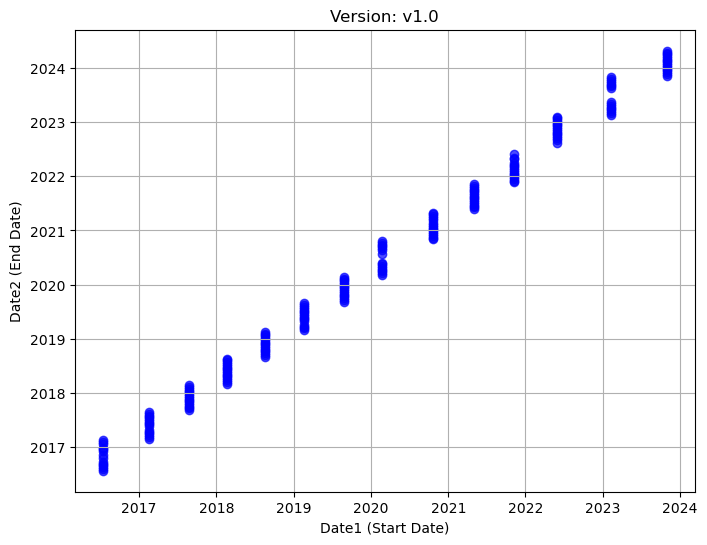

In [ ]:
# Get all downoaded netcdfs
disp_df = product.get_disp_info(nc_dir)
disp_df.head()


def plot_date1_date2(ax, df):
    """Plot start and stop dates of each ministack."""
    # Convert date1 and date2 to datetime format
    df = df.copy()
    df["date1"] = pd.to_datetime(df["date1"], format="%Y%m%d")
    df["date2"] = pd.to_datetime(df["date2"], format="%Y%m%d")

    # Plot
    ax.scatter(df.date1, df.date2, alpha=0.7, marker="o", color="b")

    # Labels and title
    ax.set_xlabel("Date1 (Start Date)")
    ax.set_ylabel("Date2 (End Date)")
    ax.set_title("Date1 vs. Date2")
    ax.grid(True)


versions = {}
for v in disp_df.version.unique():
    versions[v] = disp_df[disp_df.version == v].copy()
    print(f"{v}, size: {versions[v].shape[0]}")


for key, df in versions.items():
    fig, ax = plt.subplots(figsize=(8, 6))
    plot_date1_date2(ax, df)
    ax.set_title(f"Version: {key}")

In [41]:
%%time
# Init production stack, stacking all mini-stacks
stack_prod = disp_stack.combine_disp_product(disp_df)

Stacking into common stack
 Chunk blocks: {'time': -1, 'x': 512, 'y': 512}
Total elapsed time for disp_xr.stack.combine_disp_product: 0.14 minutes (8.49 seconds)


CPU times: user 7.85 s, sys: 634 ms, total: 8.49 s
Wall time: 8.49 s


In [42]:
stack_prod

<xarray.Dataset> Size: 675GB
Dimensions:                         (time: 210, y: 7721, x: 9462)
Coordinates:
  * y                               (y) float64 62kB 3.487e+06 ... 3.256e+06
  * x                               (x) float64 76kB 7.268e+04 ... 3.565e+05
  * time                            (time) datetime64[ns] 2kB 2016-07-14T00:0...
Data variables: (12/13)
    spatial_ref                     (time) int64 2kB 0 0 0 0 0 0 ... 0 0 0 0 0 0
    reference_time                  (time) datetime64[ns] 2kB dask.array<chunksize=(1,), meta=np.ndarray>
    displacement                    (time, y, x) float32 61GB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    short_wavelength_displacement   (time, y, x) float32 61GB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    recommended_mask                (time, y, x) float32 61GB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    connected_component_labels      (time, y, x) float32 61GB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    ...                              ...
    estimated_phase_quality         (time, y, x) float32 61GB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    persistent_scatterer_mask       (time, y, x) float32 61GB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    shp_counts                      (time, y, x) float32 61GB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    water_mask                      (time, y, x) float32 61GB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    phase_similarity                (time, y, x) float32 61GB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    timeseries_inversion_residuals  (time, y, x) float32 61GB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
Attributes:
    Conventions:         CF-1.8
    contact:             opera-sds-ops@jpl.nasa.gov
    institution:         NASA JPL
    mission_name:        OPERA
    reference_document:  JPL D-108765
    title:               OPERA_L3_DISP-S1 Product

In [48]:
# Define the reference point [lat, lon]
reference_yx = (np.float64(30.0049), np.float64(-90.1353))

# Get the epsg code for the reference point
epsg = pyproj.CRS(stack_prod.spatial_ref.attrs["crs_wkt"]).to_epsg()

# Get the reference point in UTM
ref_x_utm, ref_y_utm = latlon_to_utm(*reference_yx, epsg)

In [57]:
# Get the displacement at the reference point
ref_disp = stack_prod.sel(y=ref_y_utm, x=ref_x_utm, method="nearest").displacement

# Re-reference stack
stack_prod["displacement"] = stack_prod.displacement - ref_disp

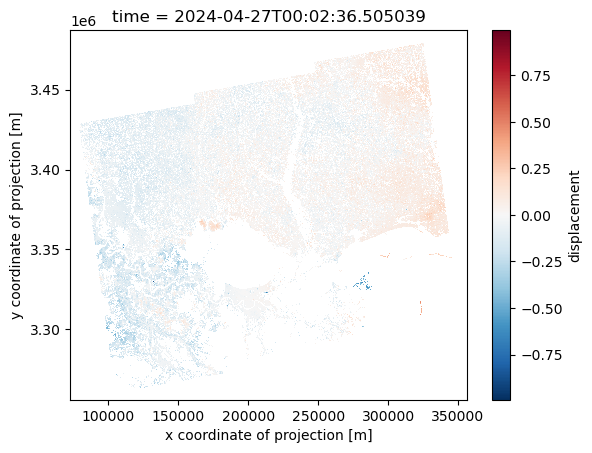

In [65]:
# Use recommended mask
stack_msk = stack_prod.where(stack_prod.recommended_mask == 1)

# Plot cummulative displacement
stack_msk.chunk({"time": 1}).isel(time=-1).displacement.plot.imshow()

## Optional: download static and auxiliary data

In [69]:
# Download up, east and north unit vector
out_dir = work_dir / "static"
static_disp = static_layers.get_static_layers(disp_df.path.iloc[0], out_dir)

Static layer files to download: 27
Static layer files to download: 27
Static layer files to download: 27
Static layer files to download: 27
Static layer files to download: 27
Stitching burst static layers to /u/aurora-r0/govorcin/01_OPERA/STAKEHOLDER/NEW_ORELEANS/workdir/static
Stitching burst static layers to /u/aurora-r0/govorcin/01_OPERA/STAKEHOLDER/NEW_ORELEANS/workdir/static
Stitching burst static layers to /u/aurora-r0/govorcin/01_OPERA/STAKEHOLDER/NEW_ORELEANS/workdir/static
Stitching burst static layers to /u/aurora-r0/govorcin/01_OPERA/STAKEHOLDER/NEW_ORELEANS/workdir/static
Stitching burst static layers to /u/aurora-r0/govorcin/01_OPERA/STAKEHOLDER/NEW_ORELEANS/workdir/static
Reprojecting los_east.tif to DISP grid
Reprojecting los_east.tif to DISP grid
Reprojecting los_east.tif to DISP grid
Reprojecting los_east.tif to DISP grid
Reprojecting los_east.tif to DISP grid
Reprojecting los_north.tif to DISP grid
Reprojecting los_north.tif to DISP grid
Reprojecting los_north.tif to 

In [70]:
# Download DEM
dem = static_layers.download_dem(disp_df.path.iloc[0], out_dir)

Reading tile imagery: 100%|██████████| 12/12 [00:06<00:00,  1.89it/s]
Saving DEM: /u/aurora-r0/govorcin/01_OPERA/STAKEHOLDER/NEW_ORELEANS/workdir/static/dem.tif
Saving DEM: /u/aurora-r0/govorcin/01_OPERA/STAKEHOLDER/NEW_ORELEANS/workdir/static/dem.tif
Saving DEM: /u/aurora-r0/govorcin/01_OPERA/STAKEHOLDER/NEW_ORELEANS/workdir/static/dem.tif
Saving DEM: /u/aurora-r0/govorcin/01_OPERA/STAKEHOLDER/NEW_ORELEANS/workdir/static/dem.tif
Saving DEM: /u/aurora-r0/govorcin/01_OPERA/STAKEHOLDER/NEW_ORELEANS/workdir/static/dem.tif


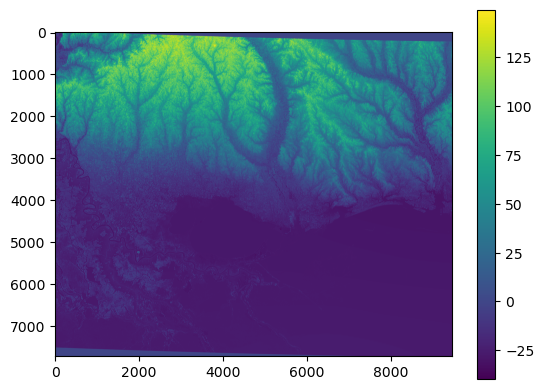

In [74]:
plt.imshow(io.open_image(dem)[0])
plt.colorbar()

# Stack Quality Metrics

In [77]:
from dask.distributed import Client

client = Client()
client.dashboard_link

'http://127.0.0.1:8787/status'

In [76]:
# Some qualty layers are common for each ministack:
# "temporal_coherence", "phase_similarity", "persistent_scatterer_mask" ,"shp_counts"
stack_quality = stack_prod.chunk(
    {"time": -1}
)  # Rechunk to take all data along dim time

ref_dates, indices = np.unique(stack_quality.reference_time, return_index=True)
ministack_ref = stack_prod.isel(time=indices)
ministack_ref = ministack_ref.chunk({"time": -1})

In [85]:
# Get percentage of PS stabilty in the stack
# Skip first date as it is all zero
pct_ps = quality_metrics.get_value_percentage(
    ministack_ref.persistent_scatterer_mask.isel(time=slice(1, None)), value=1
)

# Percentage of recommended mask
pct_mask = quality_metrics.get_value_percentage(
    ministack_ref.recommended_mask.isel(time=slice(1, None)), value=1, reverse=False
)

# Percentage of conncomponent zero
pct_conncomp = quality_metrics.get_value_percentage(
    stack_quality.connected_component_labels.isel(time=slice(1, None)),
    value=0,
    reverse=True,
)

Get percentage of persistent_scatterer_mask
Get percentage of persistent_scatterer_mask
Get percentage of persistent_scatterer_mask
Get percentage of persistent_scatterer_mask
Get percentage of persistent_scatterer_mask
Get percentage of recommended_mask
Get percentage of recommended_mask
Get percentage of recommended_mask
Get percentage of recommended_mask
Get percentage of recommended_mask
Get percentage of connected_component_labels
Get percentage of connected_component_labels
Get percentage of connected_component_labels
Get percentage of connected_component_labels
Get percentage of connected_component_labels


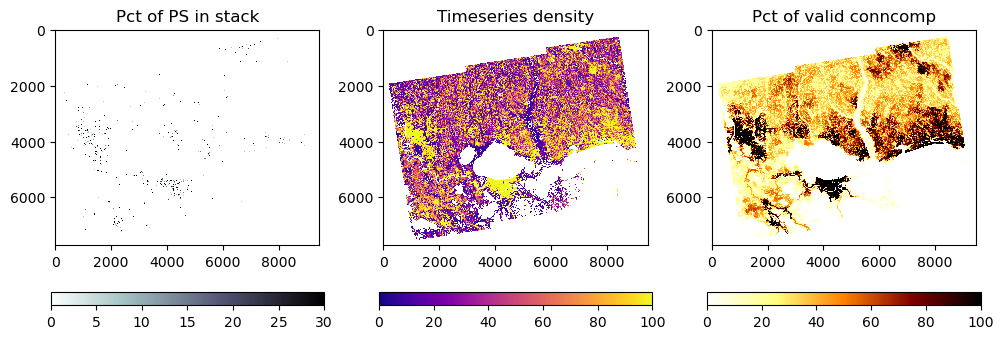

In [90]:
# Plot
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
im1 = ax[0].imshow(
    np.ma.masked_equal(pct_ps, 0), cmap="bone_r", clim=[0, 30], interpolation="nearest"
)
im2 = ax[1].imshow(
    np.ma.masked_equal(pct_mask, 0),
    cmap="plasma",
    clim=[0, 100],
    interpolation="nearest",
)
im3 = ax[2].imshow(
    np.ma.masked_equal(pct_conncomp, 0),
    cmap="afmhot_r",
    clim=[0, 100],
    interpolation="nearest",
)
for a, im in zip(ax, [im1, im2, im3]):
    fig.colorbar(im, ax=a, location="bottom")
for a, txt in zip(
    ax, ["Pct of PS in stack", "Timeseries density", "Pct of valid conncomp"]
):
    a.set_title(txt)

In [84]:
# Other quality metrics
median_tcoh = quality_metrics.get_stack_stat(
    stack_quality.temporal_coherence.isel(time=slice(1, None)), mode="median"
)
median_psim = quality_metrics.get_stack_stat(
    stack_quality.phase_similarity.isel(time=slice(1, None)), mode="median"
)
inv_res_sum = quality_metrics.get_stack_stat(
    stack_quality.timeseries_inversion_residuals.isel(time=slice(1, None)), mode="sum"
)
num_2pi_jump = inv_res_sum / (2 * np.pi)

Get median of temporal_coherence
Get median of temporal_coherence
Get median of temporal_coherence
Get median of temporal_coherence
Get median of temporal_coherence
/u/aurora-r0/govorcin/miniconda/miniforge/envs/disp_xr/lib/python3.13/site-packages/dask/_task_spec.py:757: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)
Get median of phase_similarity
Get median of phase_similarity
Get median of phase_similarity
Get median of phase_similarity
Get median of phase_similarity
Get sum of timeseries_inversion_residuals
Get sum of timeseries_inversion_residuals
Get sum of timeseries_inversion_residuals
Get sum of timeseries_inversion_residuals
Get sum of timeseries_inversion_residuals


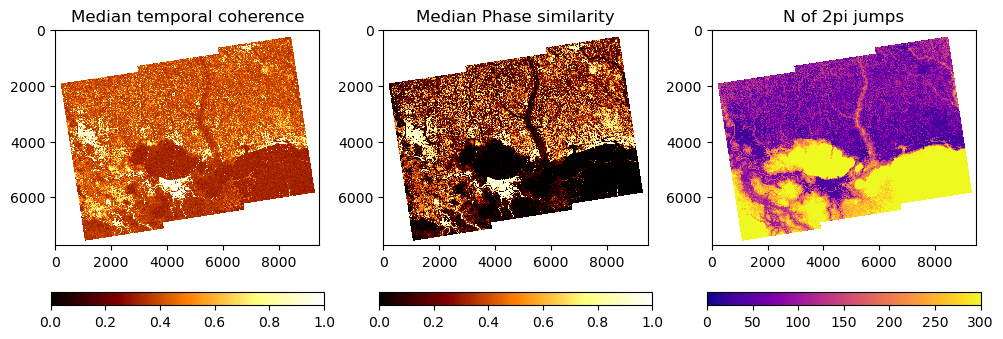

In [89]:
# Plot
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
im1 = ax[0].imshow(
    np.ma.masked_equal(median_tcoh, 0),
    cmap="afmhot",
    clim=[0, 1],
    interpolation="nearest",
)
im2 = ax[1].imshow(
    np.ma.masked_equal(median_psim, 0),
    cmap="afmhot",
    clim=[0, 1],
    interpolation="nearest",
)
im3 = ax[2].imshow(
    np.ma.masked_equal(num_2pi_jump, 0),
    cmap="plasma",
    clim=[0, 300],
    interpolation="nearest",
)
for a, im in zip(ax, [im1, im2, im3]):
    fig.colorbar(im, ax=a, location="bottom")
for a, txt in zip(
    ax, ["Median temporal coherence", "Median Phase similarity", "N of 2pi jumps"]
):
    a.set_title(txt)

In [91]:
shp_median = quality_metrics.get_stack_stat(
    ministack_ref.shp_counts.isel(time=slice(1, None)), mode="median"
)
shp_std = quality_metrics.get_stack_stat(
    ministack_ref.shp_counts.isel(time=slice(1, None)), mode="std"
)

Get median of shp_counts
Get median of shp_counts
Get median of shp_counts
Get median of shp_counts
Get median of shp_counts
Get std of shp_counts
Get std of shp_counts
Get std of shp_counts
Get std of shp_counts
Get std of shp_counts
/u/aurora-r0/govorcin/miniconda/miniforge/envs/disp_xr/lib/python3.13/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/u/aurora-r0/govorcin/miniconda/miniforge/envs/disp_xr/lib/python3.13/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/u/aurora-r0/govorcin/miniconda/miniforge/envs/disp_xr/lib/python3.13/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/u/aurora-r0/govorcin/miniconda/miniforge/envs/disp_xr/lib/python3.13/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.d

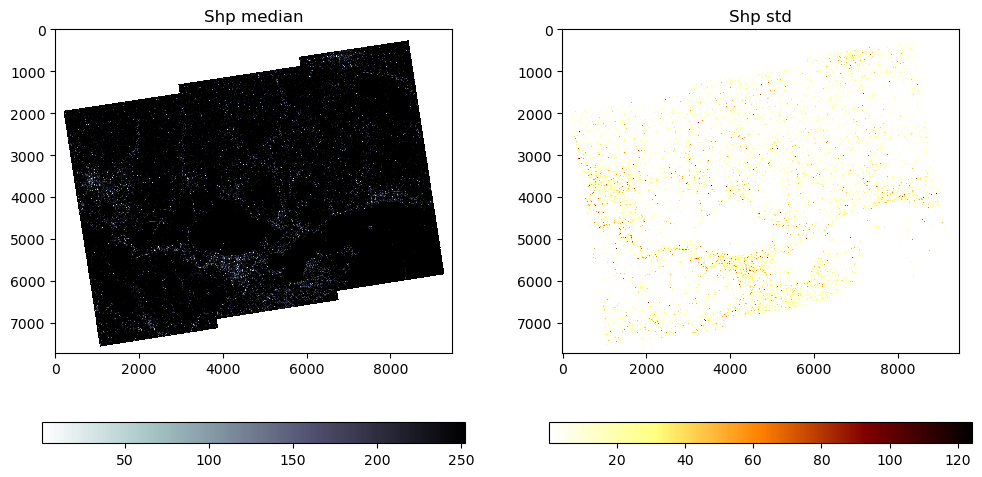

In [95]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
im1 = ax[0].imshow(
    np.ma.masked_equal(shp_median, 0), cmap="bone_r", interpolation="nearest"
)
im2 = ax[1].imshow(
    np.ma.masked_equal(shp_std, 0), cmap="afmhot_r", interpolation="nearest"
)
for a, im in zip(ax, [im1, im2, im3]):
    fig.colorbar(im, ax=a, location="bottom")
for a, txt in zip(ax, ["Shp median", "Shp std"]):
    a.set_title(txt)

# SUBSET DATA

In [103]:
bounds = [-90.3214, 29.8481, -89.9478, 30.0678]


min_x, min_y = latlon_to_utm(bounds[1], bounds[0], epsg)
max_x, max_y = latlon_to_utm(bounds[3], bounds[2], epsg)

/u/aurora-r0/govorcin/miniconda/miniforge/envs/disp_xr/lib/python3.13/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 13.37 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


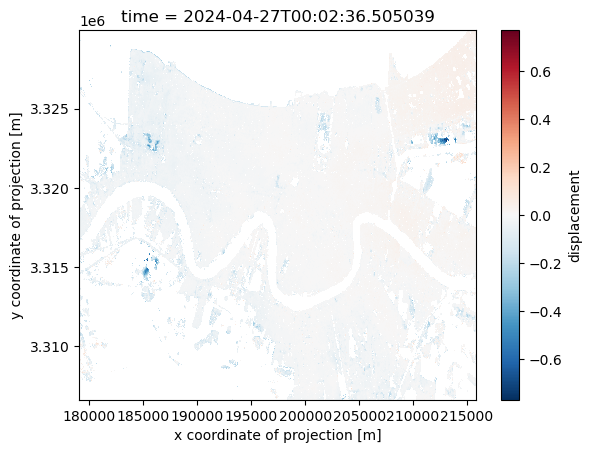

In [105]:
subset_stack = stack_msk.sel(x=slice(min_x, max_x), y=slice(max_y, min_y))
subset_stack.isel(time=-1).displacement.plot.imshow()

/u/aurora-r0/govorcin/miniconda/miniforge/envs/disp_xr/lib/python3.13/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 13.39 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


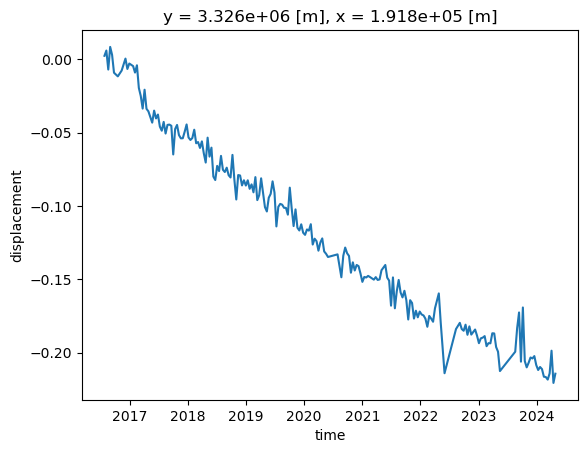

In [108]:
# pick a point on levee
xy = latlon_to_utm(30.0261, -90.1958, epsg)
subset_stack.sel(x=xy[0], y=xy[1], method="nearest").displacement.plot()

## Get Velocity

In [109]:
p = subset_stack.displacement.polyfit(
    dim="time", deg=1, skipna=True, full=True, cov=True
)

In [110]:
%%time
velocity = p.polyfit_coefficients.compute()

/u/aurora-r0/govorcin/miniconda/miniforge/envs/disp_xr/lib/python3.13/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 13.61 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 12.7 s, sys: 3.01 s, total: 15.7 s
Wall time: 24 s


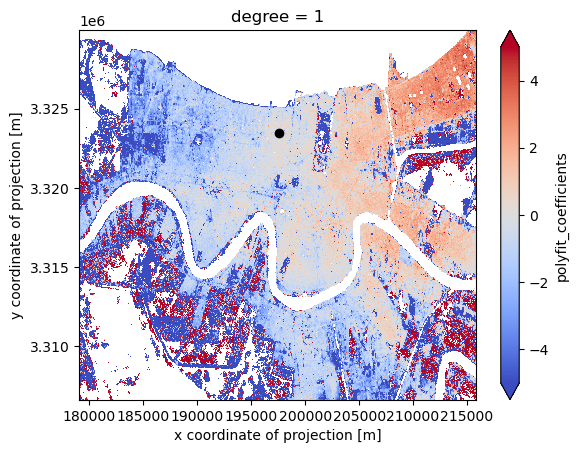

In [113]:
ns2yr = 1e9 * 60 * 60 * 24 * 365.25  # nanoseconds to years
fig, ax = plt.subplots(1)
(velocity.isel(degree=0) * ns2yr * 1e3).plot.imshow(
    ax=ax, vmin=-5, vmax=5, cmap="coolwarm"
)  # mm/yr
ax.plot(ref_x_utm, ref_y_utm, "ko")

In [115]:
client.close()